# Pre-processing Data

Address overfitting concerns

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np

In [140]:
DM = pd.read_csv('DMChartEvents.csv',usecols=["hadm_id", "subject_id", "itemid", "charttime","valuenum"])
DM = DM.sort_values(by=['charttime'])
Admissions = pd.read_csv('Admissions.csv',index_col=2)
Patients = pd.read_csv('Patients.csv',index_col=1)

In [3]:
hadm_id = []
subject_id = []
for index,row in DM.iterrows():
    if(row['hadm_id'] not in hadm_id):
        hadm_id.append(row['hadm_id'])
        subject_id.append(row['subject_id'])

In [141]:
d = {'hadm_id': hadm_id, 'subject_id': subject_id}
finalDF = pd.DataFrame(data=d)
finalDF['expire_flag'] = 0

In [142]:
for index,row in finalDF.iterrows():
    expire_flag = Admissions.loc[row['hadm_id'],'HOSPITAL_EXPIRE_FLAG']
    finalDF.at[index,'expire_flag'] = expire_flag

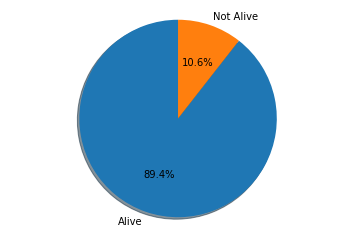

Alive:  12217
Not Alive:  1443


In [143]:
alive = 0
dead = 0
for index,row in finalDF.iterrows():
    if(row['expire_flag'] == 1):
        dead = dead+1
    else:
        alive = alive+1
        
labels = 'Alive', 'Not Alive'
sizes = [alive,dead]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
print("Alive: ", alive)
print("Not Alive: ", dead)

In [144]:
finalDF['diagnosis'] = ''
for index,row in finalDF.iterrows():
    diagnosis = Admissions.loc[row['hadm_id'],'DIAGNOSIS']
    finalDF.at[index,'diagnosis'] = diagnosis

In [145]:
finalDF['admission_type'] = ''
for index,row in finalDF.iterrows():
    admission_type = Admissions.loc[row['hadm_id'],'ADMISSION_TYPE']
    finalDF.at[index,'admission_type'] = admission_type

In [146]:
finalDF['age'] = 0
for index,row in finalDF.iterrows():
    birth = Patients.loc[row['subject_id'],'DOB']
    birth = datetime.strptime(birth, '%Y-%m-%d %H:%M:%S')
    birth_year = birth.year
    current = Admissions.loc[row['hadm_id'],'ADMITTIME']
    current = datetime.strptime(current, '%Y-%m-%d %H:%M:%S')
    current_year = current.year
    age = current_year-birth_year
    finalDF.at[index,'age'] = age

In [147]:
glucoseNumbers = {}
for index,row in DM.iterrows():
    glucoseNumbers.setdefault(row['hadm_id'], []).append(row['valuenum'])

In [148]:
finalDF['glucose'] = np.array
for index,row in finalDF.iterrows():
    glucose = glucoseNumbers[row['hadm_id']]
    finalDF.at[index,'glucose'] = glucose

In [149]:
from sklearn.preprocessing import LabelEncoder

In [150]:
le_admission_type = LabelEncoder()
finalDF['admission_type_encoded'] = le_admission_type.fit_transform(finalDF.admission_type)

In [151]:
from keras.preprocessing.text import Tokenizer

In [152]:
print(finalDF.head())

   hadm_id  subject_id  expire_flag                diagnosis admission_type  \
0   137275        9319            0        LEFT RENAL CA/SDA       ELECTIVE   
1   125380       31585            0                PNEUMONIA      EMERGENCY   
2   132722        1426            0  LEFT FRONTAL HEMORRHAGE      EMERGENCY   
3   101422       71582            0          AORTIC STENOSIS      EMERGENCY   
4   139687       68501            0     CAROTID STENOSIS/SDA       ELECTIVE   

   age                                            glucose  \
0   82  [167.0, 157.0, 157.0, 143.0, 143.0, 113.0, 113...   
1  300  [127.0, 127.0, 127.0, 113.0, 113.0, 113.0, 133...   
2   80  [172.0, 165.0, 165.0, 154.0, 154.0, 205.0, 205...   
3   76  [140.0, 164.0, 178.0, 109.0, 158.0, 157.0, 139...   
4   86                [251.0, 163.0, 121.0, 180.0, 162.0]   

   admission_type_encoded  
0                       0  
1                       1  
2                       1  
3                       1  
4                 

In [153]:
finalDF.diagnosis = finalDF.diagnosis.astype(str)
tokenizer = Tokenizer(num_words=300, split=';')
tokenizer.fit_on_texts(finalDF['diagnosis'])
finalDF['diagnosis_tokenized'] = tokenizer.texts_to_sequences(finalDF['diagnosis'])

In [154]:
print(tokenizer.word_index)
print(finalDF.head(25))

{'sda': 1, 'coronary artery disease': 2, 'congestive heart failure': 3, 'pneumonia': 4, 'chest pain': 5, 'diabetic ketoacidosis': 6, 'telemetry': 7, 'sepsis': 8, 'cath': 9, 's': 10, 'coronary artery bypass graft ': 11, 'coronary artery bypass graft': 12, 'altered mental status': 13, 'hypotension': 14, 'fever': 15, 'aortic stenosis': 16, 'gastrointestinal bleed': 17, 'stroke': 18, 'upper gi bleed': 19, 'abdominal pain': 20, 'acute renal failure': 21, 'myocardial infarction': 22, 'asthma': 23, 'lower gi bleed': 24, 'intracranial hemorrhage': 25, 'unstable angina': 26, 'urinary tract infection': 27, 'cardiac cath': 28, 'acute coronary syndrome': 29, 'shortness of breath': 30, 'transient ischemic attack': 31, 'cellulitis': 32, 'hyperglycemia': 33, 'respiratory failure': 34, 'p fall': 35, 'copd exacerbation': 36, 'renal failure': 37, 'pancreatitis': 38, 'dyspnea': 39, 'r': 40, 'hypoglycemia': 41, 'pyelonephritis': 42, 'anemia': 43, 'hypoxia': 44, ' ': 45, 'non': 46, 'seizure': 47, 'syncope'

In [155]:
glucose_count = {}
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    glucose_count[index] = 0
    for num in glucose_list:
        glucose_count[index] += 1

In [156]:
num_readings = {}

for key,value in glucose_count.items():
    if(value in num_readings):        
        num_readings[value] += 1
    else:
        num_readings[value] = 1
    

In [157]:
num = []
occur = []

for key,value in num_readings.items():
    if(value > 30):
        num.append(key)
        occur.append(value)   

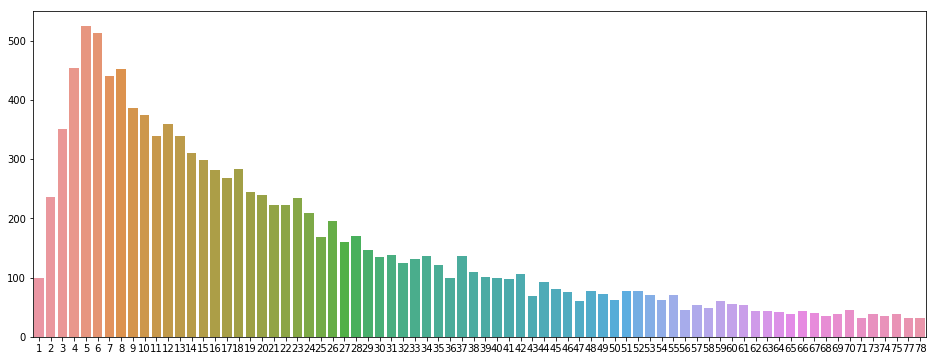

In [158]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x=num, y=occur)

In [159]:
glucose_dict = {}
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    num = index
    if (len(glucose_list) <= 25): 
        for glu in reversed(glucose_list):        
            glucose_dict.setdefault(num, []).append(glu)  
    else:
        for i in range(1,26):
            glucose_dict.setdefault(num, []).append(glucose_list[(len(glucose_list)-i)])

In [160]:
#print(glucose_dict)

In [161]:
glucoseDF = pd.DataFrame.from_dict(glucose_dict, orient='index')

In [162]:
finalDF = finalDF.join(glucoseDF)

In [163]:
diagnosis_dict = {}
for index,row in finalDF.iterrows():
    diagnosis_list = row['diagnosis_tokenized']
    num = index
    if(len(diagnosis_list) == 0):
        diagnosis_dict.setdefault(num, []).append(-1)  
    for dia in diagnosis_list:        
        diagnosis_dict.setdefault(num, []).append(int(dia))  

In [164]:
diagnosisDF = pd.DataFrame.from_dict(diagnosis_dict, orient='index')

In [165]:
diagnosisDF.columns = ['a','b','c','d','e','f','g']

In [166]:
finalDF = finalDF.join(diagnosisDF)

In [167]:
finalDF = finalDF.drop(columns=['c','d','e','f','g'])

In [168]:
def Average(lst): 
    return sum(lst) / len(lst)

In [170]:
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    glucose_list = np.array(glucose_list)
    glucose_list = glucose_list[np.logical_not(np.isnan(glucose_list))]
    if(glucose_list.size<=0):
        #finalDF.loc[index,'mean'] = 0
        finalDF.loc[index,'range'] = 0
    else:
        glucose_list = glucose_list.astype(int)
        #mean = Average(glucose_list)
        maxval = max(glucose_list)
        minval = min(glucose_list)
        #finalDF.loc[index,'mean'] = int(mean)
        finalDF.loc[index,'range'] = (maxval - minval)

for index,row in finalDF.iterrows():
    if(row['range'] == 0):
        finalDF.drop([index])
    

In [171]:
finalDF = finalDF.fillna(0)

In [172]:
print(finalDF.head(223))

     hadm_id  subject_id  expire_flag  \
0     137275        9319            0   
1     125380       31585            0   
2     132722        1426            0   
3     101422       71582            0   
4     139687       68501            0   
5     148291        9299            0   
6     116534       46467            0   
7     193449       60763            0   
8     133497       20374            0   
9     184844       29851            0   
10    179804       28857            0   
11    165465       41822            0   
12    113948       67984            0   
13    142977       61378            0   
14    157271       86102            0   
15    121811       27583            0   
16    140337       76715            0   
17    171643       76547            1   
18    144033       67248            0   
19    108386       86786            1   
20    141747       26355            0   
21    185232       46467            0   
22    126010       22841            1   
23    113177    

In [173]:
finalDF.to_csv('finalDF.csv', mode='w')

In [174]:
full = 0
not_full = 0
for index,row in finalDF.iterrows():
    if(row[32] == 0):
        not_full += 1
    else:
        full += 1
print('full: ',full)
print('not_full: ',not_full)
        

full:  6120
not_full:  7540
